# Time Series KMeans

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
# -1〜+1の間に規格化 :ToDo
def normalize(score):
    norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
    norm = norm * 2
    norm = norm - np.mean(norm, axis=0)
    return norm

In [4]:
# 分類されたクラスタを表示
def show_cluster(tm_kmeans, suptitle, title, n_row=3, n_col=3):
    center = tm_kmeans.cluster_centers_[:,:,0]
    plt.figure(figsize=(15, 10))
    plt.suptitle(suptitle, fontsize=20)
    for i in np.arange(len(center)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.set_title(f'{title}:{i+1}', fontsize=15)
        ax.plot(center[i])
    plt.tight_layout()
    plt.show()

In [5]:
class AozoraTSKmeas:

    def __init__(self, n_clusters, metrics='dtw', random_state=0):
        self.tskmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, random_state=random_state)

    def fit_transform(self, A):
        self.distances = self.tskmeans.fit_transform(A)
    
    # 分類されたクラスタを表示
    def show_cluster(self, suptitle, title, n_row=3, n_col=3):
        center = self.tskmeans.cluster_centers_[:,:,0]
        plt.figure(figsize=(15, 10))
        plt.suptitle(suptitle, fontsize=20)
        for i in np.arange(len(center)):
            ax = plt.subplot(n_row, n_col, i+1)
            ax.set_title(f'{title}:{i+1}', fontsize=15)
            ax.plot(center[i])
        plt.tight_layout()
        plt.show()

    # クラスタとクラスタに近いデータを表示
    """
    Parameters
    ----------
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    label_num: ラベル表示数
    """
    def show_cluster_sumples(self, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'center{cell} ({count})', fontsize=15)
            for idx in distance_dicts_sort_key[:disp_num]:
                ax.plot(A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                top_stories.append(f'{novel} ({author})\n{url}')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(self.tskmeans.cluster_centers_[label].ravel(), c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    
    # クラスタに近い小説を表示
    """
    Parameters
    ----------
    kmeans: TimeSeriesKMenasのインスタンス
    distances: 中心からの距離
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    """
    def show_novels(self, aozora_data, disp_num=20):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        print(f'CLUSTER NUM:{n_clusters}')
        print('NO: 作品名 [副題] (作者,文の長さ)\n')
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # クラスタに近い小説を表示
            top_stories = []
            for idx in distance_dicts_sort_key[:disp_num]:
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                subtitle = aozora_data.iloc[idx].loc['副題']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                length = int(aozora_data.iloc[idx].loc['length'])
                if type(subtitle) is float:
                    top_stories.append(f'{novel} ({author},{length})\n{url}')
                else:
                    top_stories.append(f'{novel} [{subtitle}] ({author},{length})\n{url}')
            xlabel = f'Top Stories of center{label+1}:\n'
            for i in range(disp_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            print(xlabel)

In [6]:
# 使うデータは1036冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_0805.csv'
TARGET_PATH = 'data/target2.csv'

In [7]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
score_df.head()

S00       S01       S02       S03       S04       S05       S06  \
13  0.791536  0.737968  0.829343  0.794293  0.724665  0.707668  0.620669   
19  0.319629  0.242864  0.144180  0.055158  0.210209  0.000000  0.128723   
24  0.749562  0.727724  0.721075  0.648729  0.764811  0.627247  0.634754   
30  0.473785  0.473785  0.652944  0.622040  0.663769  0.799352  0.982744   
41  0.900899  0.952689  1.000000  0.928408  0.802310  0.760143  0.699925   

         S07       S08       S09  ...       S90       S91       S92       S93  \
13  0.607199  0.584499  0.626389  ...  0.754139  0.782878  0.784226  0.576965   
19  0.272368  0.439170  0.593644  ...  0.717217  0.688295  0.751741  0.783382   
24  0.640822  0.792777  0.844474  ...  0.690379  0.640809  0.828280  0.806064   
30  0.966812  0.851591  0.907304  ...  0.101549  0.142406  0.285570  0.270750   
41  0.759109  0.660739  0.726829  ...  0.094422  0.246499  0.291265  0.373439   

         S94       S95       S96       S97       S98       S99  
13  0.534152  0.601299  0.612696  0.611167  0.664706  0.736535  
19  0.774904  0.930222  0.874313  0.949715  1.000000  0.901567  
24  0.754045  0.906671  0.896347  0.869153  0.901117  0.933473  
30  0.320434  0.441094  0.464494  0.548101  0.610829  0.517892  
41  0.445357  0.450839  0.390509  0.337263  0.402609  0.459209  

[5 rows x 100 columns]

In [8]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

対象  人物ID      氏名            読み   作品ID    作品名   副題        作品名読み  \
0  True   374   饗庭 篁村      あえば こうそん  45754     良夜  NaN         りょうや   
1  True   879  芥川 竜之介  あくたがわ りゅうのすけ     73  或敵打の話  NaN  あるかたきうちのはなし   

                                            図書カードURL  \
0  https://www.aozora.gr.jp/cards/000374/card4575...   
1  https://www.aozora.gr.jp/cards/000879/card73.html   

                                         テキストファイルURL  \
0  https://www.aozora.gr.jp/cards/000374/files/45...   
1  https://www.aozora.gr.jp/cards/000879/files/73...   

                                          テキストファイルパス  \
0  ./bunko/cards/000374/files/edit/45754_ruby_236...   
1   ./bunko/cards/000879/files/edit/73_ruby_1217.txt   

                                           スコアファイルパス   備考  length  
0  ./bunko/cards/000374/files/score/45754_ruby_23...  NaN   119.0  
1  ./bunko/cards/000879/files/score/73_ruby_1217.txt  NaN   280.0

In [9]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(3)

対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   

                                             図書カードURL  \
13  https://www.aozora.gr.jp/cards/000879/card124....   
19  https://www.aozora.gr.jp/cards/000879/card69.html   
24  https://www.aozora.gr.jp/cards/000879/card77.html   

                                          テキストファイルURL  ...       S90  \
13  https://www.aozora.gr.jp/cards/000879/files/12...  ...  0.754139   
19  https://www.aozora.gr.jp/cards/000879/files/69...  ...  0.717217   
24  https://www.aozora.gr.jp/cards/000879/files/77...  ...  0.690379   

         S91       S92       S93       S94       S95       S96       S97  \
13  0.782878  0.784226  0.576965  0.534152  0.601299  0.612696  0.611167   
19  0.688295  0.751741  0.783382  0.774904  0.930222  0.874313  0.949715   
24  0.640809  0.828280  0.806064  0.754045  0.906671  0.896347  0.869153   

         S98       S99  
13  0.664706  0.736535  
19  1.000000  0.901567  
24  0.901117  0.933473  

[3 rows x 114 columns]

In [10]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

TargetID    対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
0        13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
1        19  True   879  芥川 竜之介  あくたがわ りゅうのすけ    69      河童  NaN       かっぱ   
2        24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   
3        30  True   879  芥川 竜之介  あくたがわ りゅうのすけ    38    戯作三昧  NaN   げさくざんまい   
4        41  True   879  芥川 竜之介  あくたがわ りゅうのすけ    59     邪宗門  NaN   じゃしゅうもん   

                                            図書カードURL  ...       S90       S91  \
0  https://www.aozora.gr.jp/cards/000879/card124....  ...  0.754139  0.782878   
1  https://www.aozora.gr.jp/cards/000879/card69.html  ...  0.717217  0.688295   
2  https://www.aozora.gr.jp/cards/000879/card77.html  ...  0.690379  0.640809   
3  https://www.aozora.gr.jp/cards/000879/card38.html  ...  0.101549  0.142406   
4  https://www.aozora.gr.jp/cards/000879/card59.html  ...  0.094422  0.246499   

        S92       S93       S94       S95       S96       S97       S98  \
0  0.784226  0.576965  0.534152  0.601299  0.612696  0.611167  0.664706   
1  0.751741  0.783382  0.774904  0.930222  0.874313  0.949715  1.000000   
2  0.828280  0.806064  0.754045  0.906671  0.896347  0.869153  0.901117   
3  0.285570  0.270750  0.320434  0.441094  0.464494  0.548101  0.610829   
4  0.291265  0.373439  0.445357  0.450839  0.390509  0.337263  0.402609   

        S99  
0  0.736535  
1  0.901567  
2  0.933473  
3  0.517892  
4  0.459209  

[5 rows x 115 columns]

In [11]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

S00       S01       S02       S03       S04       S05       S06  \
0     0.791536  0.737968  0.829343  0.794293  0.724665  0.707668  0.620669   
1     0.319629  0.242864  0.144180  0.055158  0.210209  0.000000  0.128723   
2     0.749562  0.727724  0.721075  0.648729  0.764811  0.627247  0.634754   
3     0.473785  0.473785  0.652944  0.622040  0.663769  0.799352  0.982744   
4     0.900899  0.952689  1.000000  0.928408  0.802310  0.760143  0.699925   
...        ...       ...       ...       ...       ...       ...       ...   
1144  1.000000  0.886321  0.760418  0.683147  0.649745  0.606923  0.571151   
1145  0.928336  1.000000  0.946976  0.868300  0.888023  0.706569  0.560303   
1146  1.000000  0.909603  0.793596  0.745868  0.727928  0.758194  0.740752   
1147  0.528431  0.438392  0.438334  0.539294  0.604325  0.652928  0.757941   
1148  1.000000  0.936297  0.894863  0.804954  0.771635  0.654813  0.599213   

           S07       S08       S09  ...       S90       S91       S92  \
0     0.607199  0.584499  0.626389  ...  0.754139  0.782878  0.784226   
1     0.272368  0.439170  0.593644  ...  0.717217  0.688295  0.751741   
2     0.640822  0.792777  0.844474  ...  0.690379  0.640809  0.828280   
3     0.966812  0.851591  0.907304  ...  0.101549  0.142406  0.285570   
4     0.759109  0.660739  0.726829  ...  0.094422  0.246499  0.291265   
...        ...       ...       ...  ...       ...       ...       ...   
1144  0.517130  0.492479  0.494035  ...  0.180267  0.172682  0.146108   
1145  0.661318  0.782652  0.888690  ...  0.472828  0.545340  0.500948   
1146  0.763606  0.817574  0.829033  ...  0.687817  0.752808  0.738397   
1147  0.918232  0.951555  0.909684  ...  0.440108  0.449598  0.485174   
1148  0.558161  0.495424  0.486509  ...  0.501346  0.473209  0.441937   

           S93       S94       S95       S96       S97       S98       S99  
0     0.576965  0.534152  0.601299  0.612696  0.611167  0.664706  0.736535  
1     0.783382  0.774904  0.930222  0.874313  0.949715  1.000000  0.901567  
2     0.806064  0.754045  0.906671  0.896347  0.869153  0.901117  0.933473  
3     0.270750  0.320434  0.441094  0.464494  0.548101  0.610829  0.517892  
4     0.373439  0.445357  0.450839  0.390509  0.337263  0.402609  0.459209  
...        ...       ...       ...       ...       ...       ...       ...  
1144  0.091107  0.070645  0.042570  0.032390  0.094500  0.142480  0.098496  
1145  0.563695  0.563695  0.697739  0.767883  0.759698  0.974234  0.763724  
1146  0.750526  0.830493  0.896725  0.919508  0.899834  0.873144  0.925176  
1147  0.381715  0.325619  0.357203  0.409554  0.360593  0.315495  0.401312  
1148  0.478669  0.486706  0.501930  0.510489  0.528429  0.556842  0.533268  

[1149 rows x 100 columns]

In [12]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [13]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1149, 100), -1.1072807157884734, 1.0693278680169627, 3.339365337775928e-18)

In [14]:
# 軸を追加しておく
A = A[:,:,np.newaxis]
A.shape

(1149, 100, 1)

## metric:euclidean

In [15]:
km1 = TimeSeriesKMeans(n_clusters=9, metric='euclidean', random_state=0)
km1.fit(A)

TimeSeriesKMeans(n_clusters=9, random_state=0)

In [16]:
km1.cluster_centers_.shape

(9, 100, 1)

In [17]:
center1 = km1.cluster_centers_[:,:,0]
center1.shape

(9, 100)

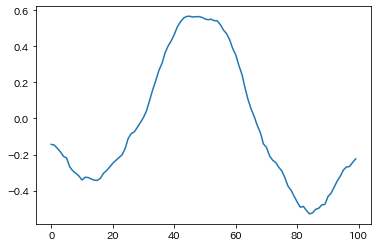

In [18]:
plt.plot(center1[2])

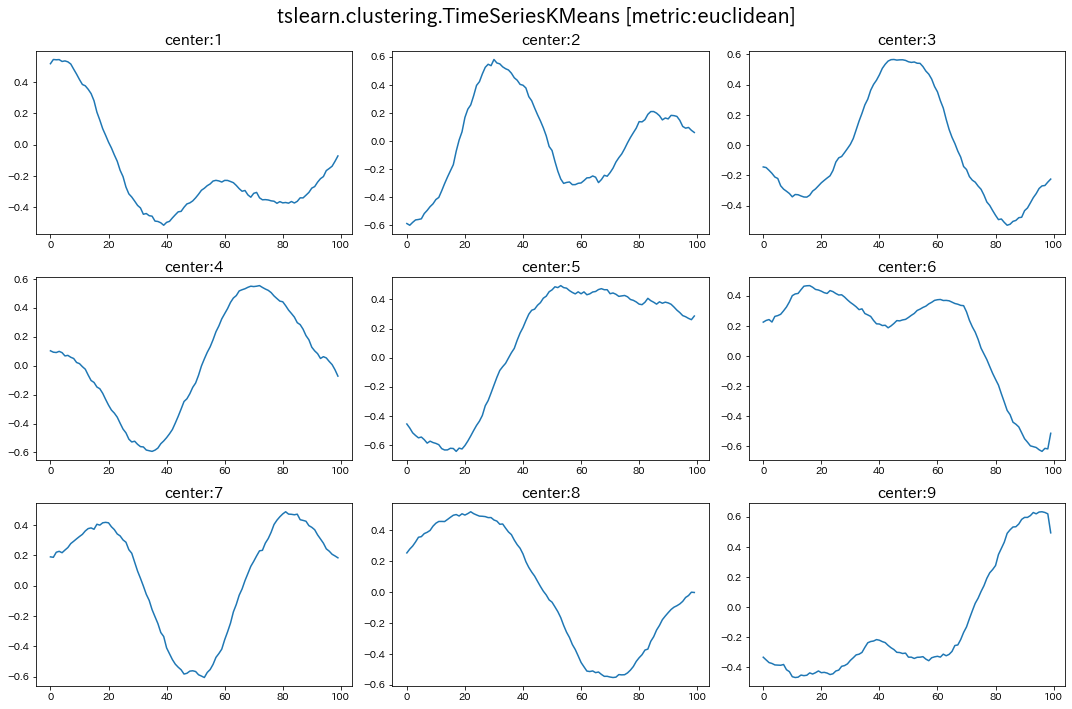

In [19]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:euclidean]'
show_cluster(km1, suptitle, 'center')

## metric:dtw

In [20]:
km2 = TimeSeriesKMeans(n_clusters=9, metric='dtw', random_state=0)
km2.fit(A)

TimeSeriesKMeans(metric='dtw', n_clusters=9, random_state=0)

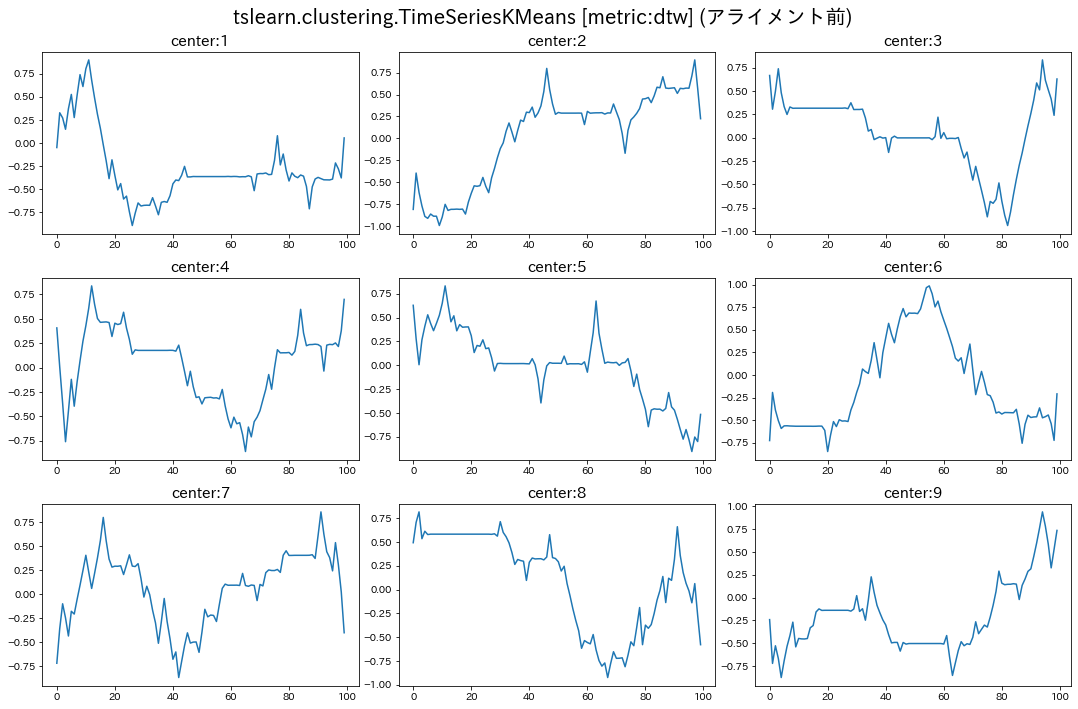

In [21]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)'
show_cluster(km2, suptitle, 'center')

In [22]:
np.unique(km2.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [23]:
km2_pred = km2.predict(A)

In [24]:
distances = km2.transform(A)
distances.shape

(1036, 9)

In [25]:
np.where(km2.labels_==0)[0].shape

(91,)

In [26]:
keys = np.where(km2.labels_==0)[0]
values = distances[km2.labels_==0][:, 0]
distance_dicts = {k: v for k, v in zip(keys, values)}
distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
# np.where(km2.labels_==0)[0], distances[km2.labels_==0][:, 0]

In [27]:
distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
print(distance_dicts_sort_key[:20])

[715, 355, 607, 436, 864, 200, 314, 633, 293, 960, 861, 153, 1034, 36, 964, 654, 663, 509, 487, 925]


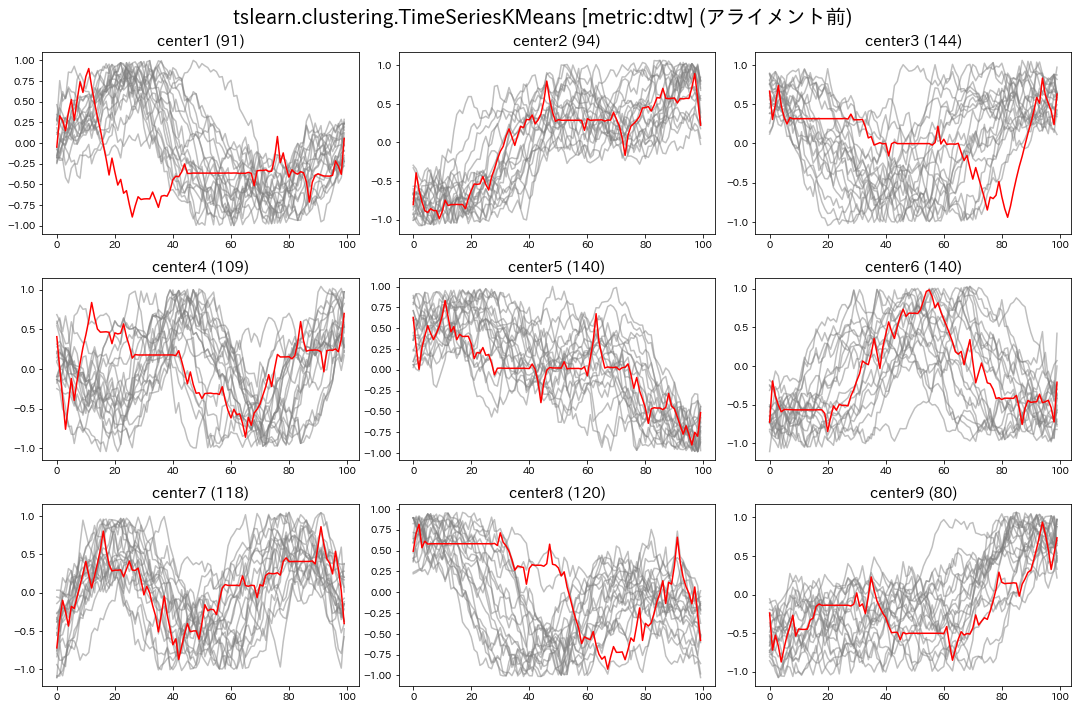

In [28]:
n_clusters = len(np.unique(km2.labels_)) 
disp_num = 20
plt.figure(figsize=(15, 10))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km2.labels_==label)[0]
    values = distances[km2.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(3, 3, cell)
    count = len(distance_dicts_sort_key)
    ax.set_title(f'center{cell} ({count})', fontsize=15)    
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
    plt.plot(km2.cluster_centers_[label].ravel(), c='red')
plt.tight_layout()
plt.show()

## metric:softdtw

In [29]:
# 遅いです．．
km3 = TimeSeriesKMeans(n_clusters=9, metric='softdtw', random_state=0)
km3.fit(A)

TimeSeriesKMeans(metric='softdtw', n_clusters=9, random_state=0)

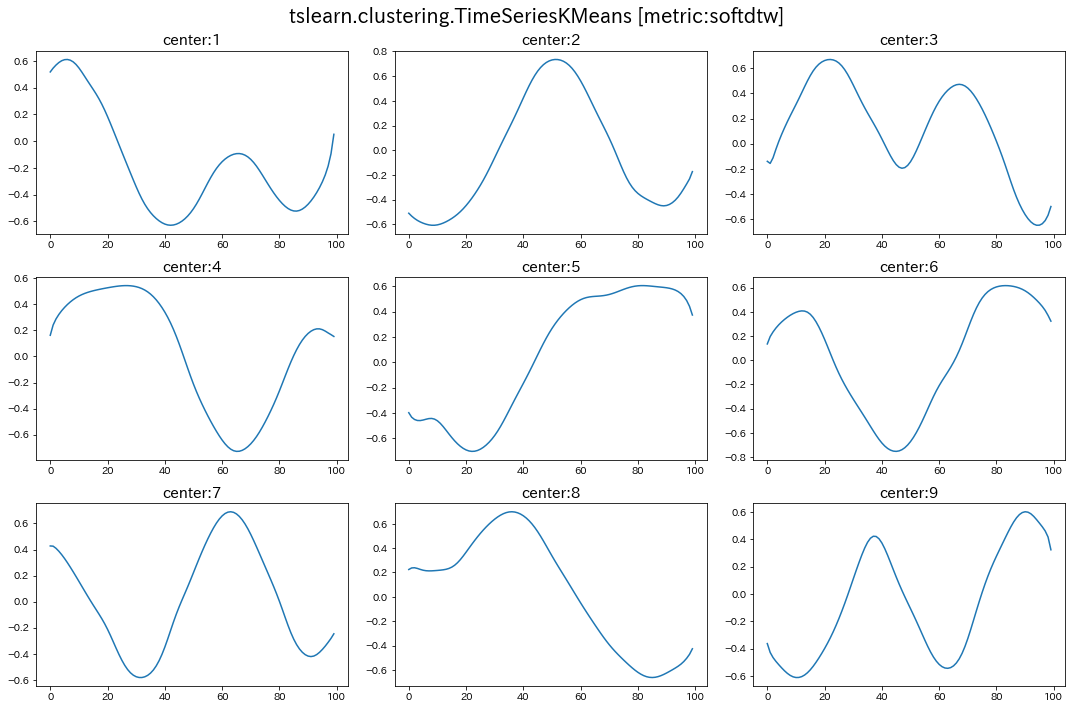

In [30]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:softdtw]'
show_cluster(km3, suptitle, 'center')

## エルボー法

In [15]:
distortions = []
tskms = []
for n in range(1, 11):
    print('n_clusters:', n)
    km = TimeSeriesKMeans(n_clusters=n, metric='dtw', random_state=0)
    km.fit(A)
    tskms.append(km)
    distortions.append(km.inertia_)

n_clusters: 1
n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9
n_clusters: 10


In [16]:
# 作成したモデルを保存しておく
for i in range(len(tskms)):
    # print(i, f'data/tskm_cluster{i+1}.hdf5')
    file_path = f'data/tskm_cluster{i+1}.hdf5'
    if os.path.isfile(file_path):
        os.remove(file_path)
    tskms[i].to_hdf5(file_path)

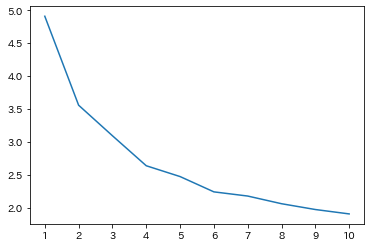

In [17]:
plt.plot(distortions)
plt.xticks(range(10), range(1,11))
plt.show()

## シルエット法

In [19]:
# シルエット法で検証する
silhouette_scores = []
for n in range(1, 10):
    print(f'calc.. silhouette score [cluster{n+1}]')
    ss = silhouette_score(A, tskms[n].labels_, 'dtw')
    silhouette_scores.append(ss)
    print(f'silhouette score [cluster{n+1}]: {ss}')

calc.. silhouette score [cluster2]
silhouette score [cluster2]: 0.2789105749232615
calc.. silhouette score [cluster3]
silhouette score [cluster3]: 0.2463286777755006
calc.. silhouette score [cluster4]
silhouette score [cluster4]: 0.22086873353071249
calc.. silhouette score [cluster5]
silhouette score [cluster5]: 0.18870216401319734
calc.. silhouette score [cluster6]
silhouette score [cluster6]: 0.19028549516520762
calc.. silhouette score [cluster7]
silhouette score [cluster7]: 0.16287837648069384
calc.. silhouette score [cluster8]
silhouette score [cluster8]: 0.1521151082973305
calc.. silhouette score [cluster9]
silhouette score [cluster9]: 0.14497991792887832
calc.. silhouette score [cluster10]
silhouette score [cluster10]: 0.1595316594239703


In [20]:
for i in range(len(silhouette_scores)):
    print(f'silhouette score [cluster{i+2}]: {round(silhouette_scores[i],3)}')

silhouette score [cluster2]: 0.279
silhouette score [cluster3]: 0.246
silhouette score [cluster4]: 0.221
silhouette score [cluster5]: 0.189
silhouette score [cluster6]: 0.19
silhouette score [cluster7]: 0.163
silhouette score [cluster8]: 0.152
silhouette score [cluster9]: 0.145
silhouette score [cluster10]: 0.16


In [35]:
# シルエットスコアを保存しておく
np.save('data/silhouette_scores.npy', np.array(silhouette_scores))

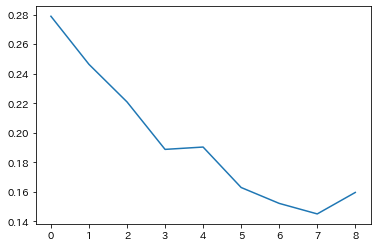

In [36]:
sil_scores = np.load('data/silhouette_scores.npy')
plt.plot(sil_scores)
plt.show()

In [ ]:
# 保存されたファイルからロードする場合は以下を実施
tskms = []
for n in range(10):
    file_path = f'data/tskm_cluster{n+1}.hdf5'
    if os.path.isfile(file_path):
        print(f'Load: tskms[{n}]=',file_path, )
        tskms.append(TimeSeriesKMeans.from_hdf5(file_path))
    else:
        print('Skip: ',file_path)

In [ ]:
silhouette_score(A, tskms[3].labels_, 'dtw')

In [ ]:
silhouette_score(A, tskms[5].labels_, 'dtw')

## クラスタ数:4

In [37]:
# クラスタ数:4で実施
km4 = AozoraTSKmeas(4)
km4.fit_transform(A)

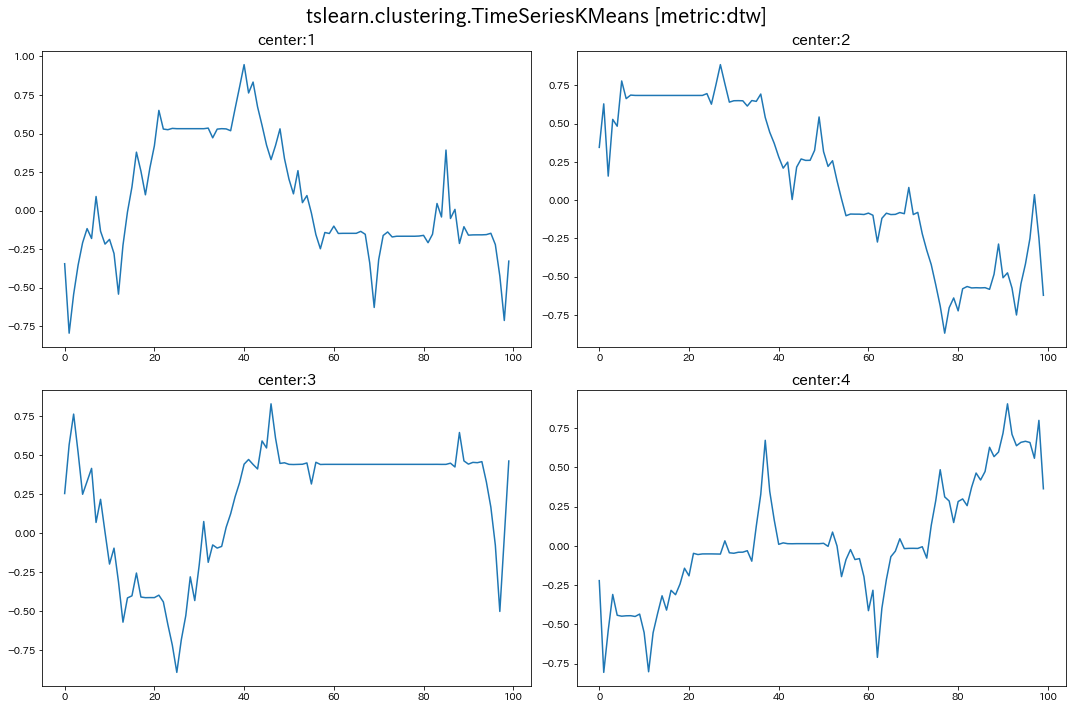

In [38]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km4.show_cluster(suptitle, 'center', 2, 2)

In [39]:
# クラスタ付近の小説を表示
km4.show_novels(df_merge, 5)

CLUSTER NUM:4
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 独房 (小林 多喜二,579)
https://www.aozora.gr.jp/cards/000156/card43684.html
02: 親子 (有島 武郎,552)
https://www.aozora.gr.jp/cards/000025/card1143.html
03: おせん (邦枝 完二,2976)
https://www.aozora.gr.jp/cards/001261/card46687.html
04: 大菩薩峠 [41 椰子林の巻] (中里 介山,3343)
https://www.aozora.gr.jp/cards/000283/card4512.html
05: Ｄ坂の殺人事件 (江戸川 乱歩,583)
https://www.aozora.gr.jp/cards/001779/card56650.html

Top Stories of center2:
01: 十二神貝十郎手柄話 (国枝 史郎,2529)
https://www.aozora.gr.jp/cards/000255/card43621.html
02: 人外魔境 [05 水棲人] (小栗 虫太郎,598)
https://www.aozora.gr.jp/cards/000125/card1067.html
03: 夜明け前 [01 第一部上] (島崎 藤村,5595)
https://www.aozora.gr.jp/cards/000158/card1504.html
04: 明治開化　安吾捕物 [03 その二　密室大犯罪] (坂口 安吾,712)
https://www.aozora.gr.jp/cards/001095/card43205.html
05: 灰色の記憶 (久坂 葉子,2160)
https://www.aozora.gr.jp/cards/001052/card4968.html

Top Stories of center3:
01: 前途なお (小山 清,614)
https://www.aozora.gr.jp/cards/001867/card58190.html
02: 死の前後 (豊島 与志雄,5

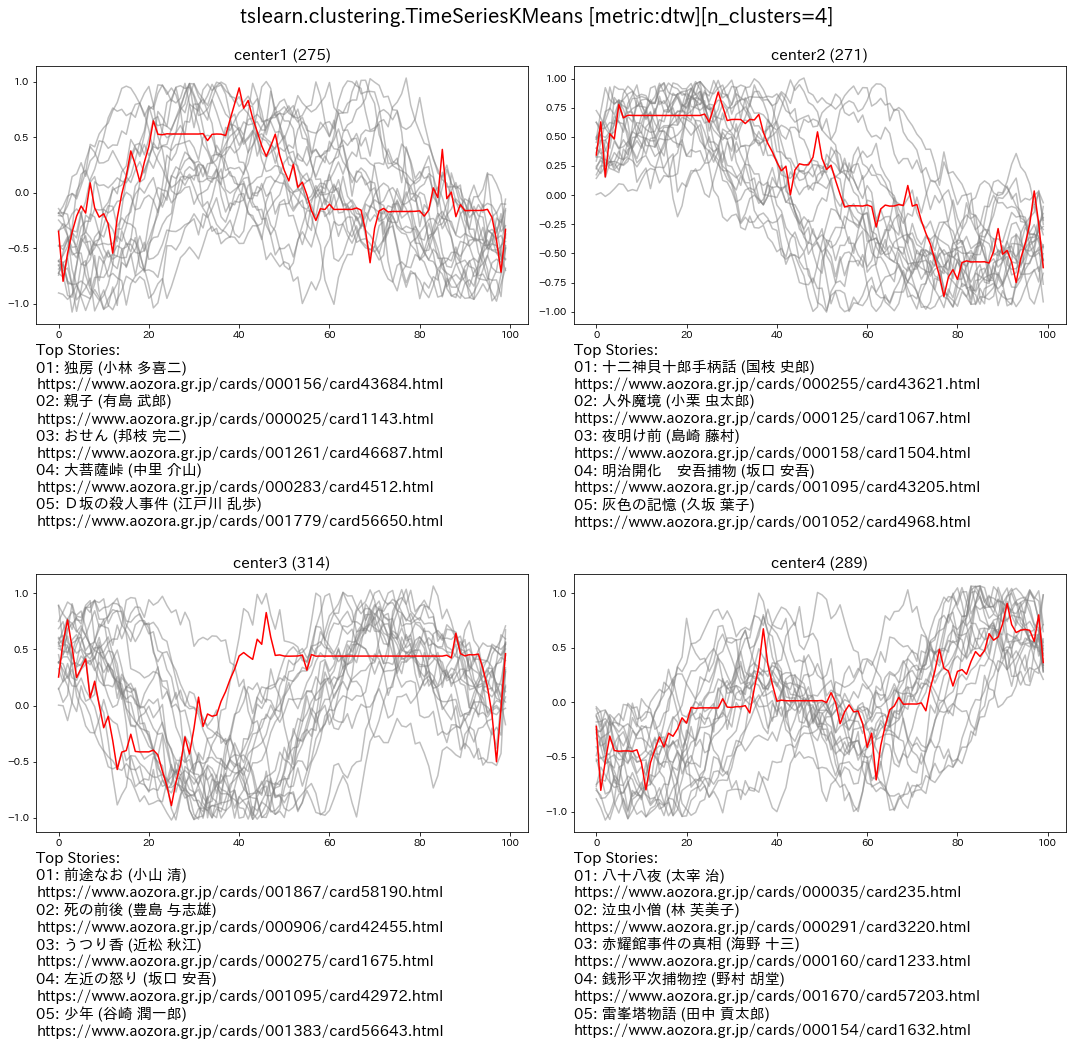

In [40]:
# クラスタとその付近の小説を視覚化
km4.show_cluster_sumples(df_merge, plot_rows=2, plot_cols=2)

## クラスタ数:5

In [41]:
# クラスタ数:5で実施
km5 = AozoraTSKmeas(5)
km5.fit_transform(A)

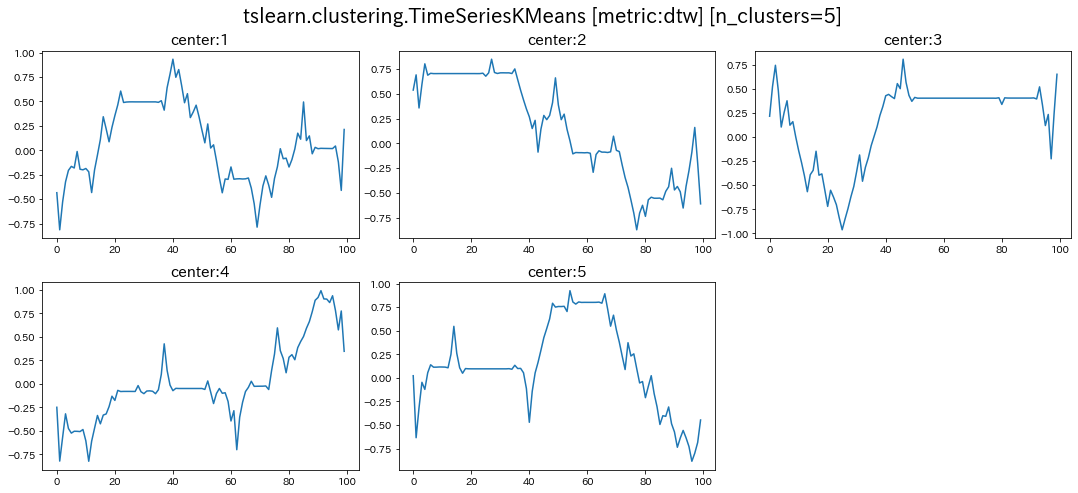

In [42]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=5]'
km5.show_cluster(suptitle, 'center')

In [43]:
# クラスタ付近の小説を表示
km5.show_novels(df_merge, 5)

CLUSTER NUM:5
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 死の予告 (野村 胡堂,531)
https://www.aozora.gr.jp/cards/001670/card56709.html
02: 別れの辞 (豊島 与志雄,642)
https://www.aozora.gr.jp/cards/000906/card42462.html
03: 新書太閤記 [06 第六分冊] (吉川 英治,6871)
https://www.aozora.gr.jp/cards/001562/card56757.html
04: ダス・ゲマイネ (太宰 治,757)
https://www.aozora.gr.jp/cards/000035/card42945.html
05: 銭形平次捕物控 [068 辻斬綺談] (野村 胡堂,527)
https://www.aozora.gr.jp/cards/001670/card56274.html

Top Stories of center2:
01: 人外魔境 [05 水棲人] (小栗 虫太郎,598)
https://www.aozora.gr.jp/cards/000125/card1067.html
02: 明治開化　安吾捕物 [03 その二　密室大犯罪] (坂口 安吾,712)
https://www.aozora.gr.jp/cards/001095/card43205.html
03: 夜明け前 [01 第一部上] (島崎 藤村,5595)
https://www.aozora.gr.jp/cards/000158/card1504.html
04: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
05: ロマンスと縁談 (佐々木 邦,771)
https://www.aozora.gr.jp/cards/001750/card55831.html

Top Stories of center3:
01: 新書太閤記 [08 第八分冊] (吉川 英治,6480)
https://www.aozora.gr.jp/card

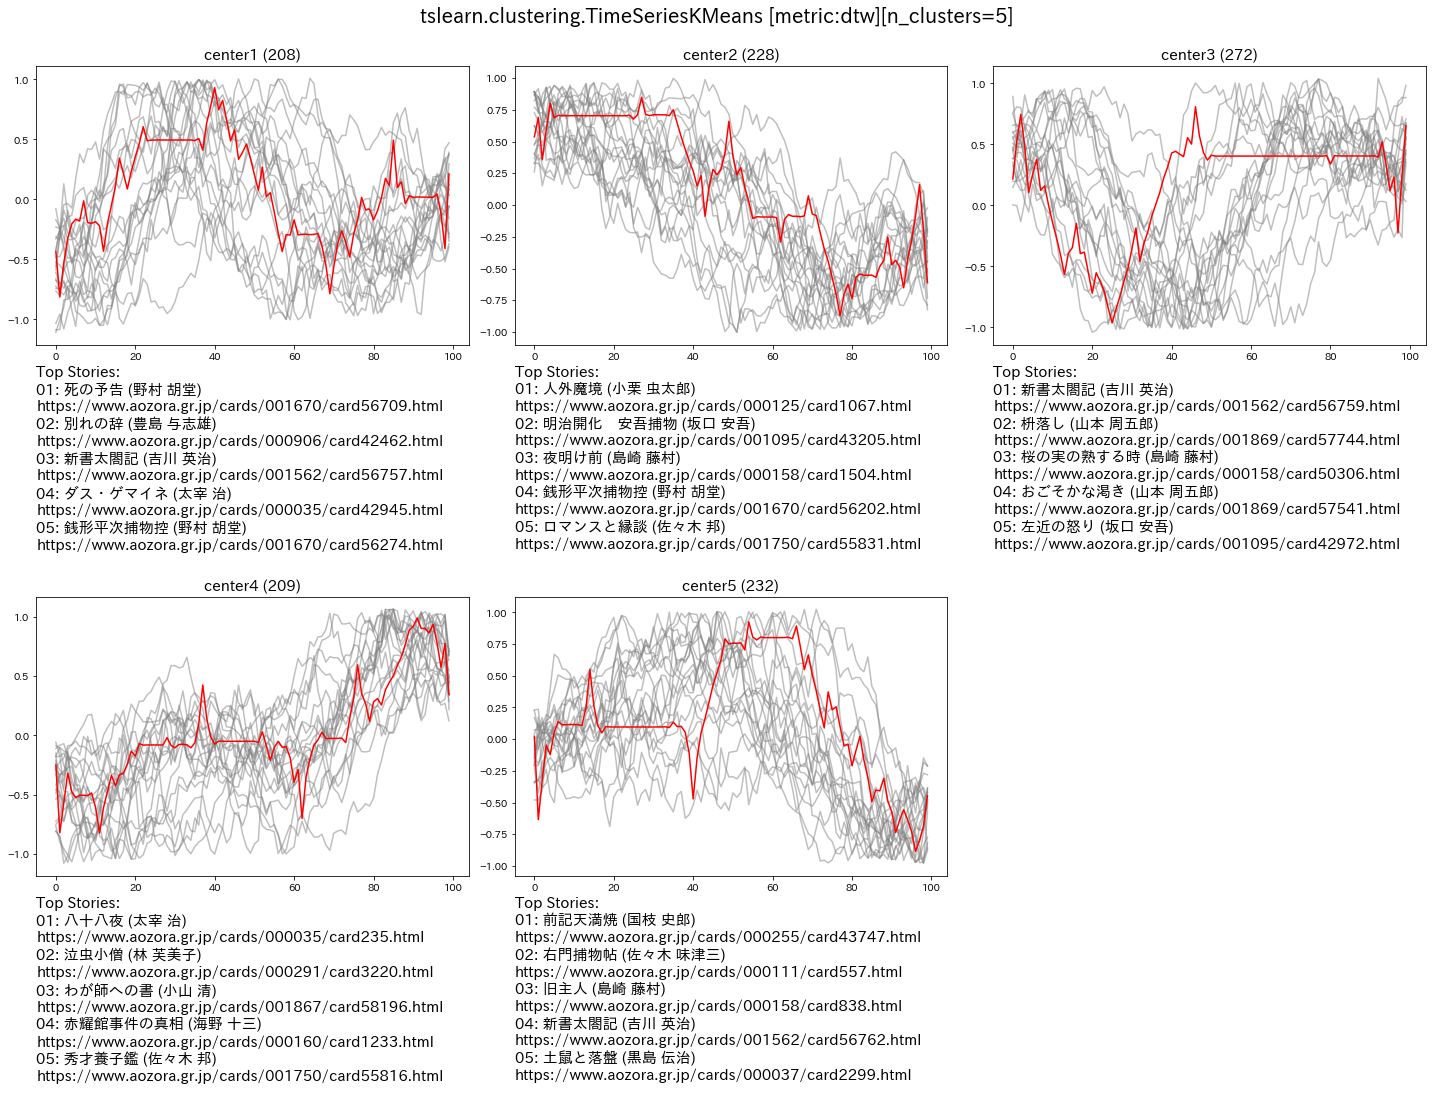

In [44]:
# クラスタとその付近の小説を視覚化
km5.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:6

In [45]:
# クラスタ数:6で実施
km6 = AozoraTSKmeas(6)
km6.fit_transform(A)

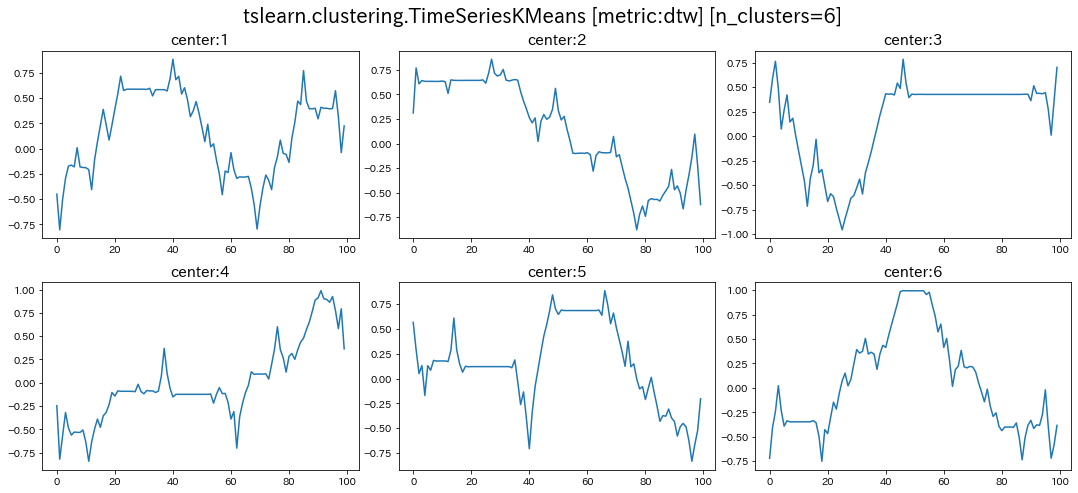

In [46]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=6]'
km6.show_cluster(suptitle, 'center')

In [47]:
# クラスタ付近の小説を表示
km6.show_novels(df_merge, 5)

CLUSTER NUM:6
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
02: 鳴門秘帖 [03 木曾の巻] (吉川 英治,1538)
https://www.aozora.gr.jp/cards/001562/card52405.html
03: 沼夫人 (泉 鏡花,1179)
https://www.aozora.gr.jp/cards/000050/card4742.html
04: 黒手組 (江戸川 乱歩,510)
https://www.aozora.gr.jp/cards/001779/card57185.html
05: 聖女人像 (豊島 与志雄,516)
https://www.aozora.gr.jp/cards/000906/card42739.html

Top Stories of center2:
01: 人外魔境 [05 水棲人] (小栗 虫太郎,598)
https://www.aozora.gr.jp/cards/000125/card1067.html
02: 十二神貝十郎手柄話 (国枝 史郎,2529)
https://www.aozora.gr.jp/cards/000255/card43621.html
03: キャラコさん [05 鴎] (久生 十蘭,1053)
https://www.aozora.gr.jp/cards/001224/card47490.html
04: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
05: 伊太利亜の古陶 (宮本 百合子,519)
https://www.aozora.gr.jp/cards/000311/card1953.html

Top Stories of center3:
01: おごそかな渇き (山本 周五郎,690)
https://www.aozora.gr.jp/cards/001869/card57541.html
02: 新書太閤記 [08 第八分冊] (吉

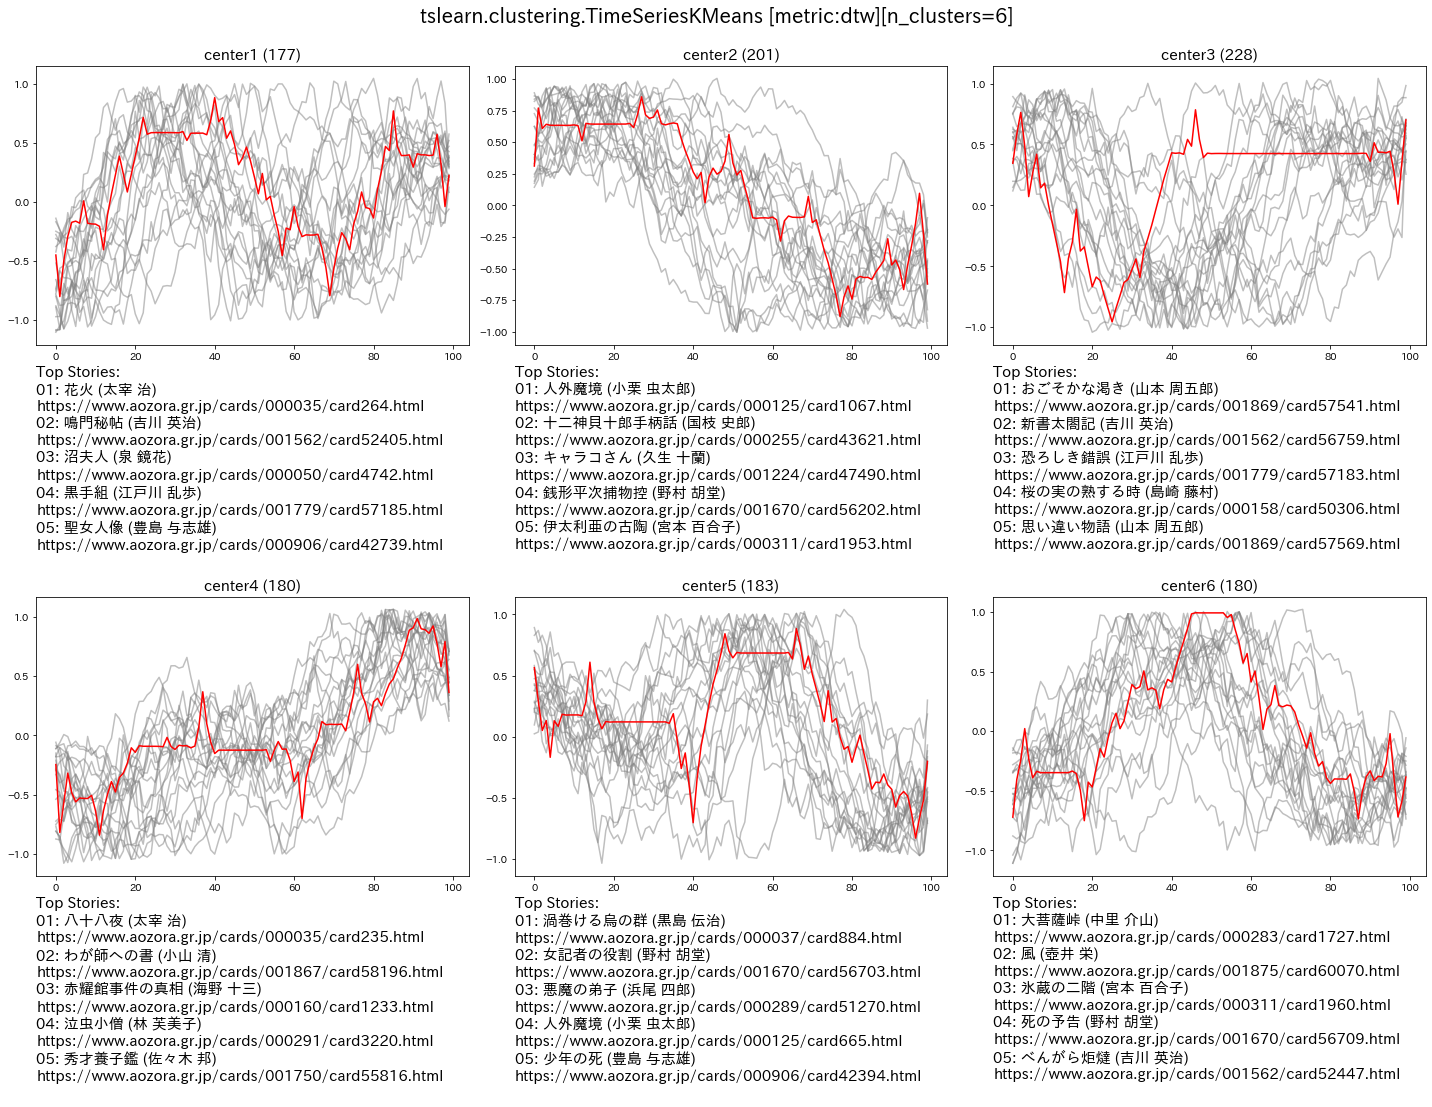

In [48]:
# クラスタとその付近の小説を視覚化
km6.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:7

In [49]:
# クラスタ数4で実施
km7 = AozoraTSKmeas(7)
km7.fit_transform(A)


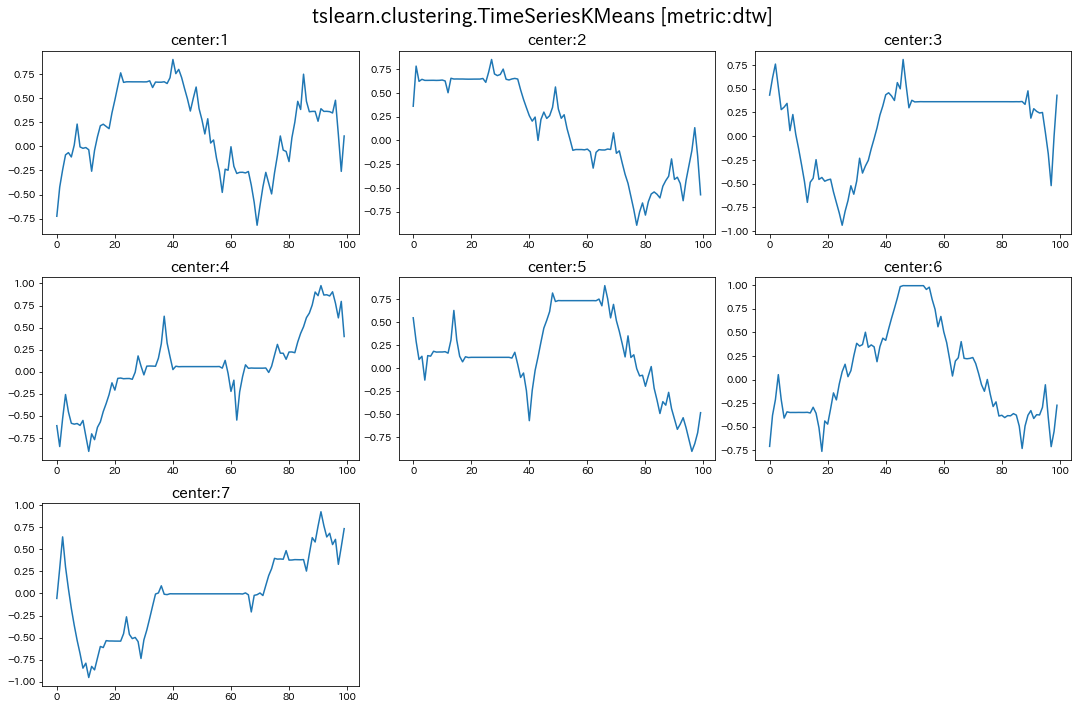

In [50]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km7.show_cluster(suptitle, 'center')

In [51]:
# クラスタ付近の小説を表示
km7.show_novels(df_merge, 5)

CLUSTER NUM:7
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 少将滋幹の母 (谷崎 潤一郎,1365)
https://www.aozora.gr.jp/cards/001383/card56847.html
02: 鳴門秘帖 [03 木曾の巻] (吉川 英治,1538)
https://www.aozora.gr.jp/cards/001562/card52405.html
03: 大菩薩峠 [17 黒業白業の巻] (中里 介山,2192)
https://www.aozora.gr.jp/cards/000283/card4503.html
04: 石ころ路 (田畑 修一郎,543)
https://www.aozora.gr.jp/cards/000273/card4355.html
05: 血曼陀羅紙帳武士 (国枝 史郎,2431)
https://www.aozora.gr.jp/cards/000255/card45211.html

Top Stories of center2:
01: 人外魔境 [05 水棲人] (小栗 虫太郎,598)
https://www.aozora.gr.jp/cards/000125/card1067.html
02: キャラコさん [05 鴎] (久生 十蘭,1053)
https://www.aozora.gr.jp/cards/001224/card47490.html
03: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
04: 明治開化　安吾捕物 [03 その二　密室大犯罪] (坂口 安吾,712)
https://www.aozora.gr.jp/cards/001095/card43205.html
05: 焦点を合せる (夢野 久作,888)
https://www.aozora.gr.jp/cards/000096/card2103.html

Top Stories of center3:
01: うつり香 (近松 秋江,1297)
https://www.aozora.gr.jp/cards/000275/c

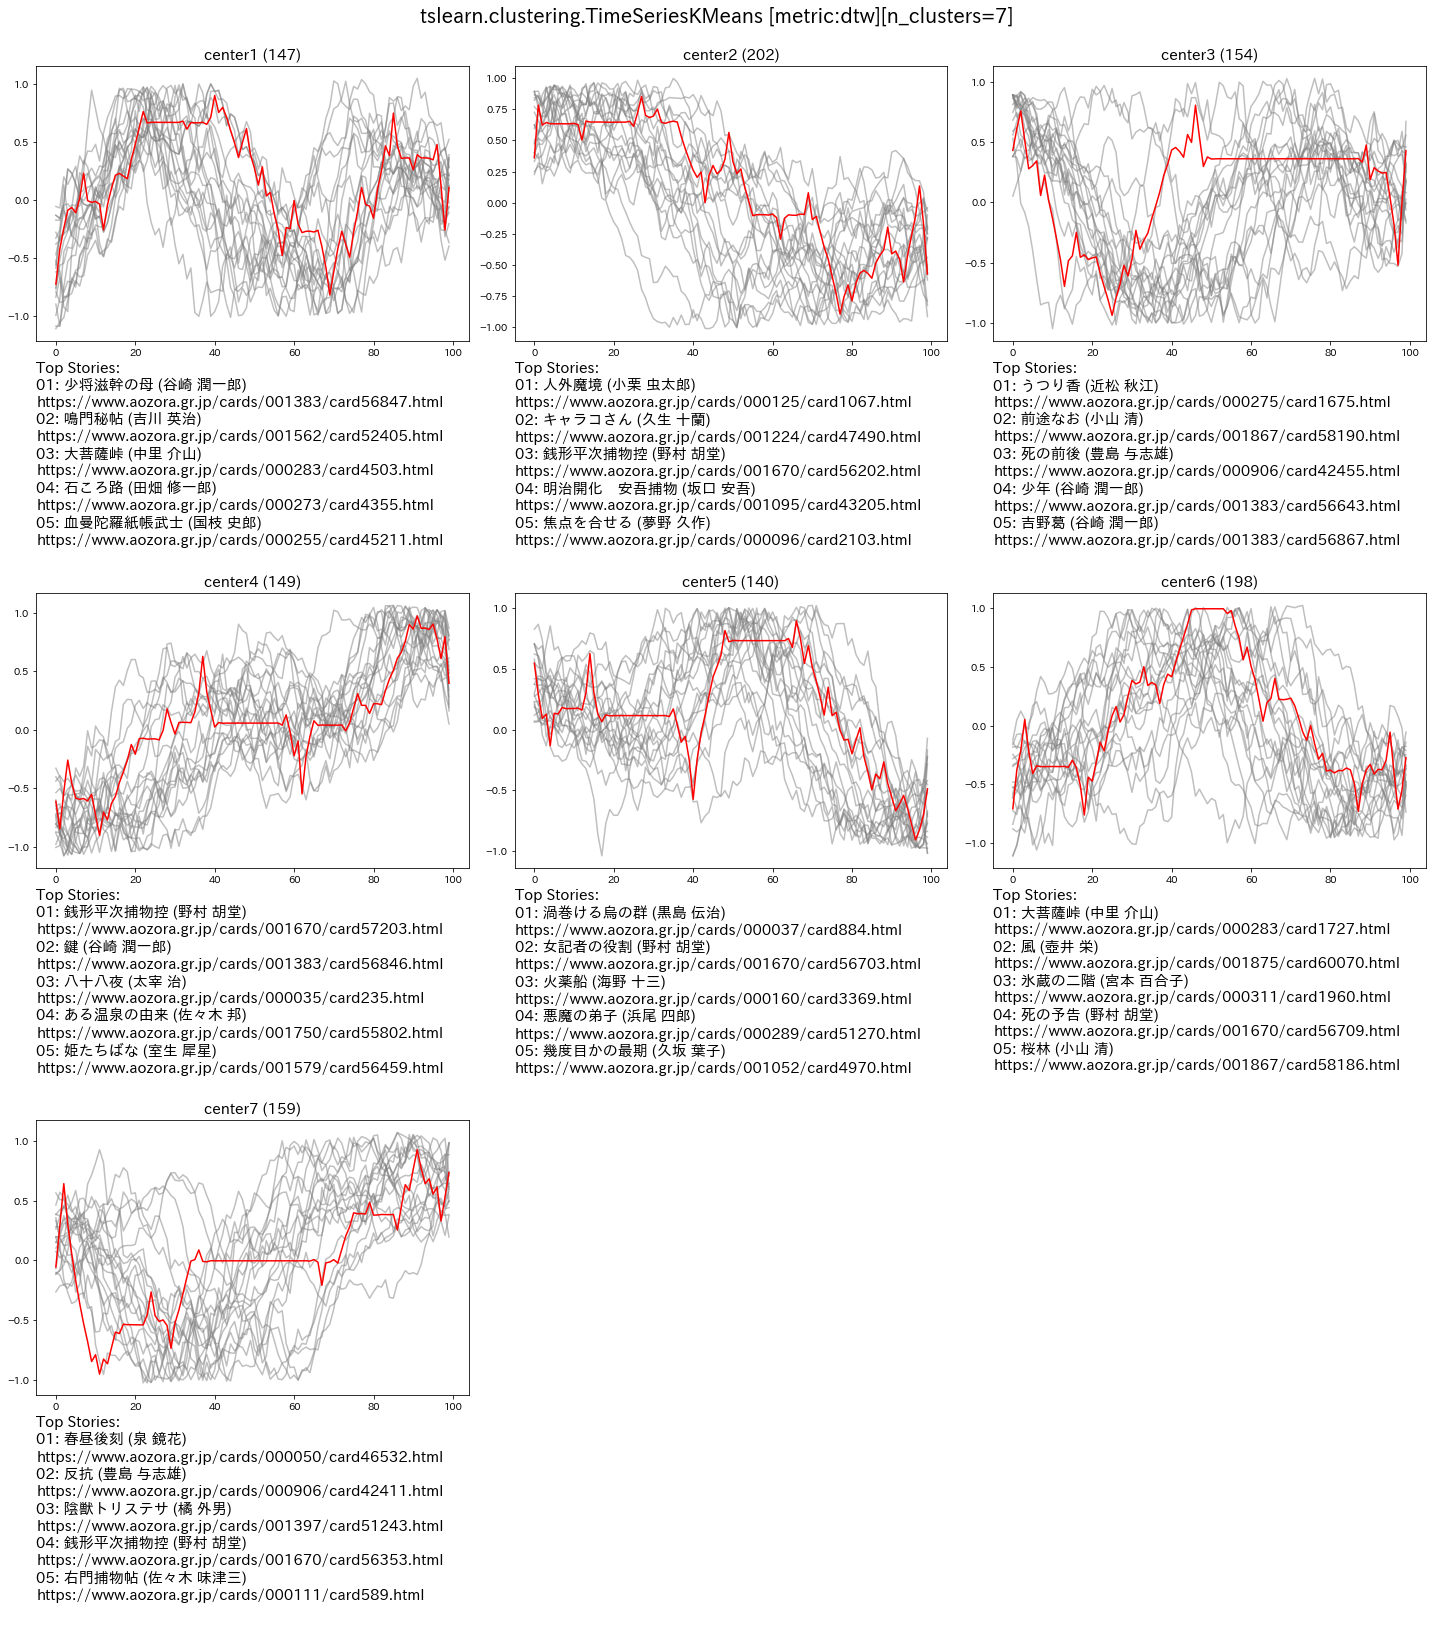

In [67]:
# クラスタとその付近の小説を視覚化
km7.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:8

In [53]:
# クラスタ数8で実施
km8 = AozoraTSKmeas(8)
km8.fit_transform(A)

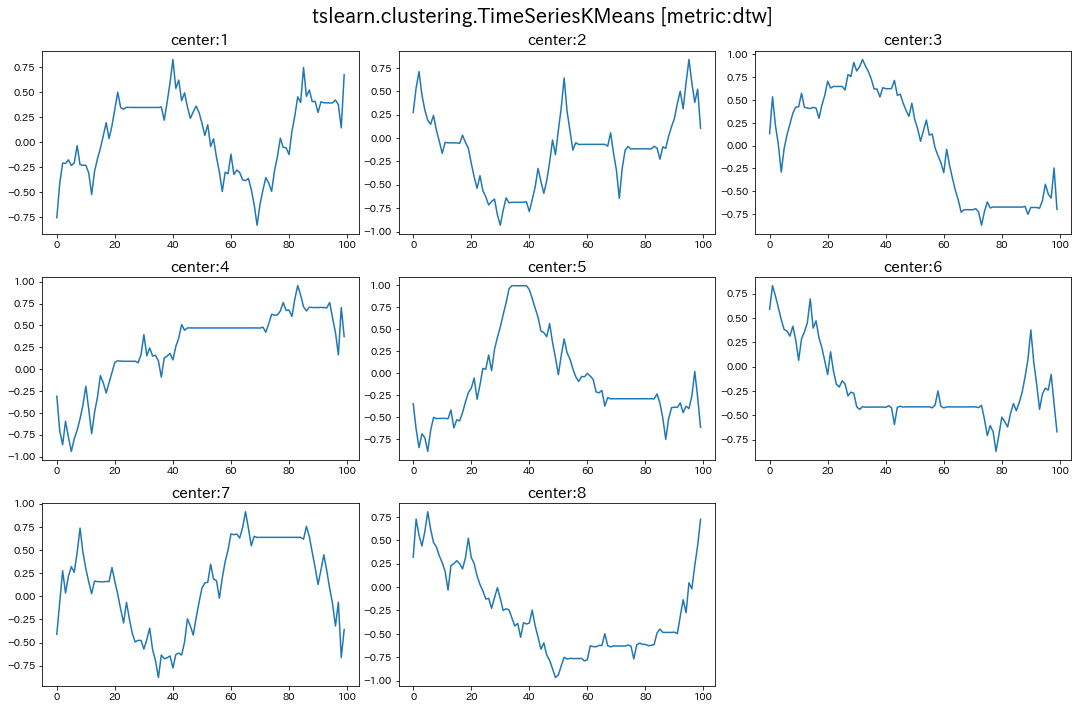

In [54]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km8.show_cluster(suptitle, 'center')

In [55]:
# クラスタ付近の小説を表示
km8.show_novels(df_merge, 5)

CLUSTER NUM:8
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
02: 聖女人像 (豊島 与志雄,516)
https://www.aozora.gr.jp/cards/000906/card42739.html
03: 三国志 [05 臣道の巻] (吉川 英治,5811)
https://www.aozora.gr.jp/cards/001562/card52413.html
04: 右門捕物帖 [24 のろいのわら人形] (佐々木 味津三,999)
https://www.aozora.gr.jp/cards/000111/card586.html
05: 右門捕物帖 [15 京人形大尽] (佐々木 味津三,565)
https://www.aozora.gr.jp/cards/000111/card576.html

Top Stories of center2:
01: 姥捨 (太宰 治,597)
https://www.aozora.gr.jp/cards/000035/card2256.html
02: いたずら小僧日記 (佐々木 邦,2711)
https://www.aozora.gr.jp/cards/001750/card55803.html
03: ドーヴィル物語 (岡本 かの子,675)
https://www.aozora.gr.jp/cards/000076/card46942.html
04: 春の盗賊 (太宰 治,925)
https://www.aozora.gr.jp/cards/000035/card266.html
05: おさん (山本 周五郎,825)
https://www.aozora.gr.jp/cards/001869/card57537.html

Top Stories of center3:
01: 明治開化　安吾捕物 [07 その六　血を見る真珠] (坂口 安吾,819)
https://www.aozora.gr.jp/cards/001095/card43209.html
02: 鉄の処女 (大倉 燁子,58

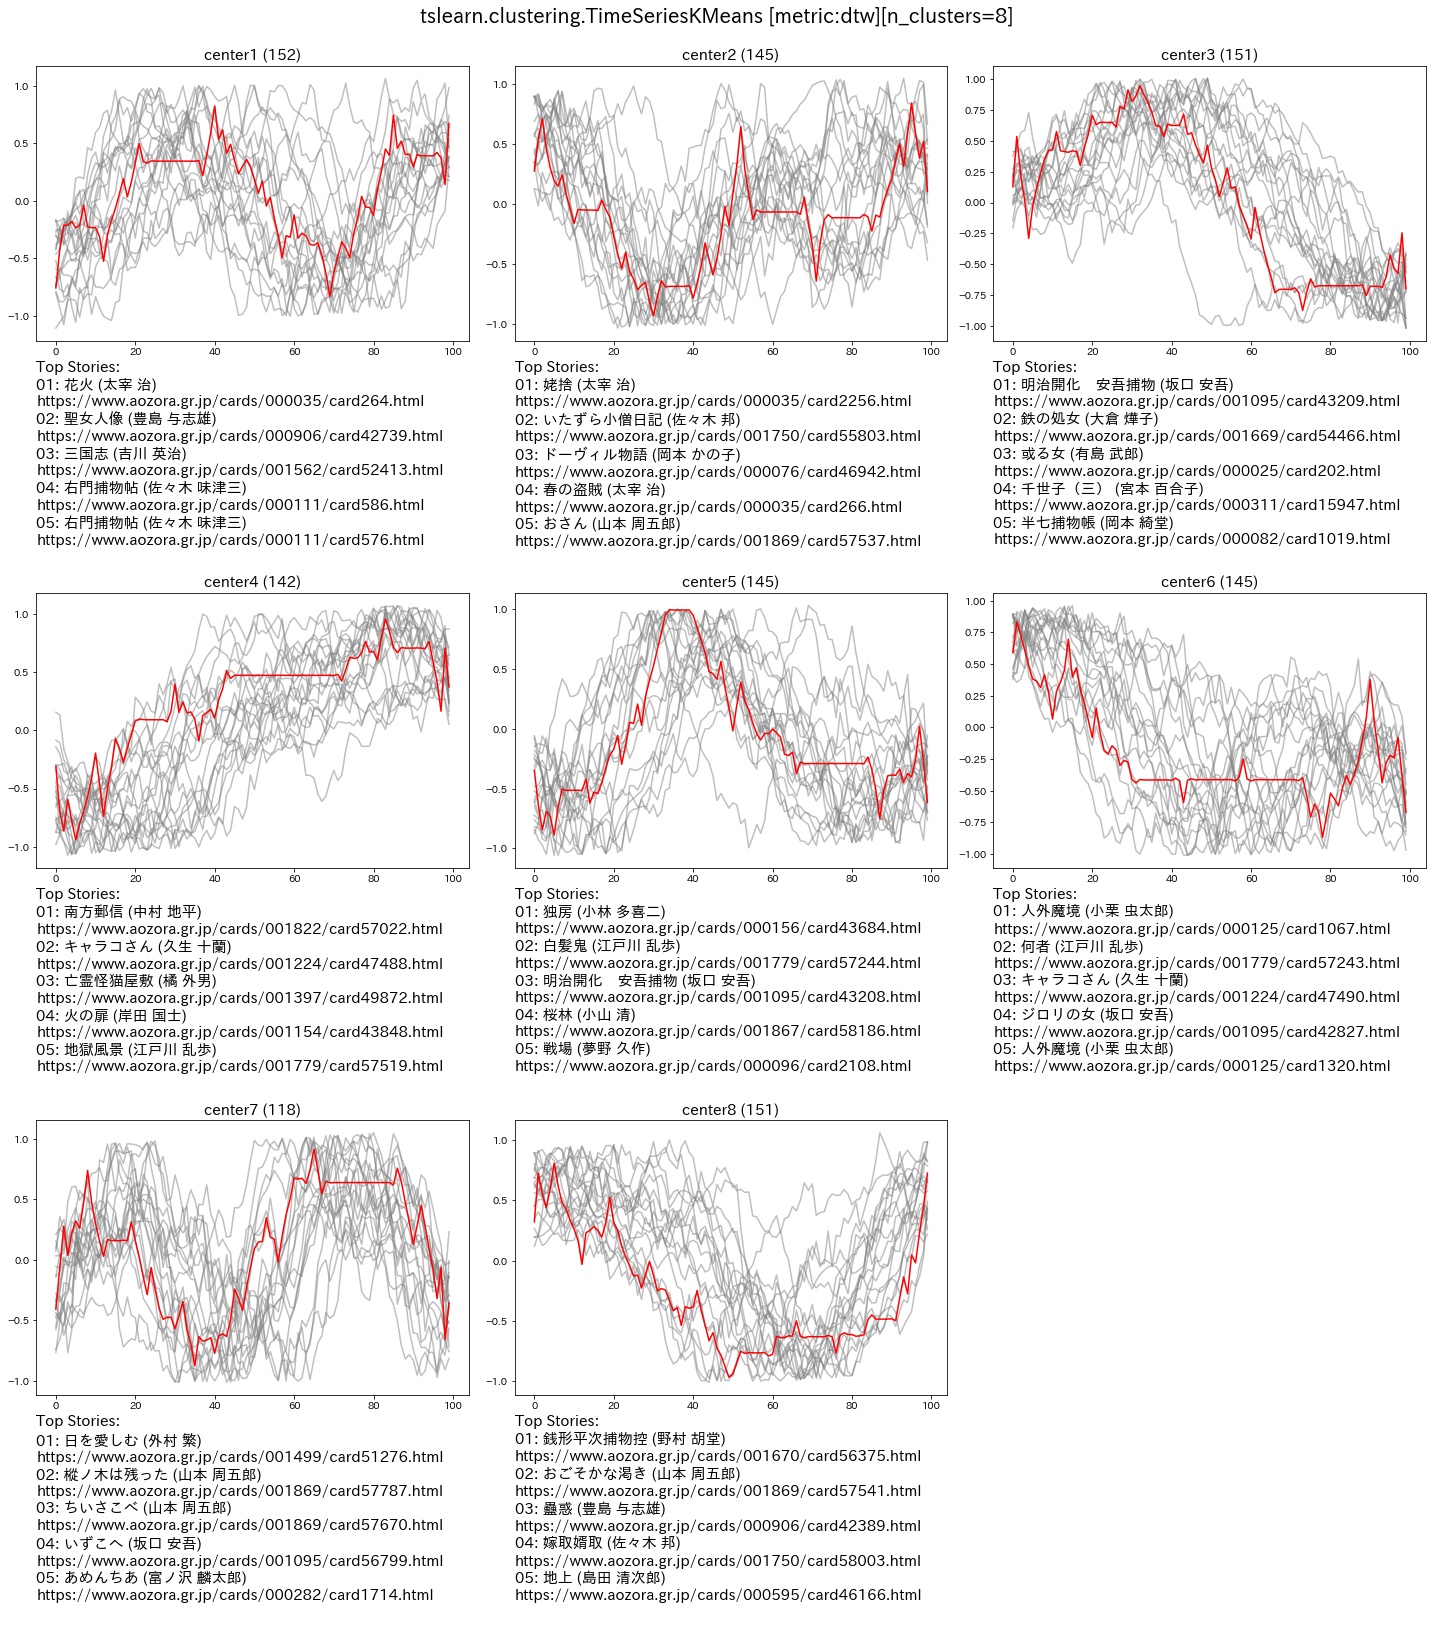

In [66]:
# クラスタとその付近の小説を視覚化
km8.show_cluster_sumples(df_merge, figsize=(20, 23), plot_rows=3, plot_cols=3)

## クラスタ数:9

In [57]:
# クラスタ数9で実施
km9 = AozoraTSKmeas(9)
km9.fit_transform(A)

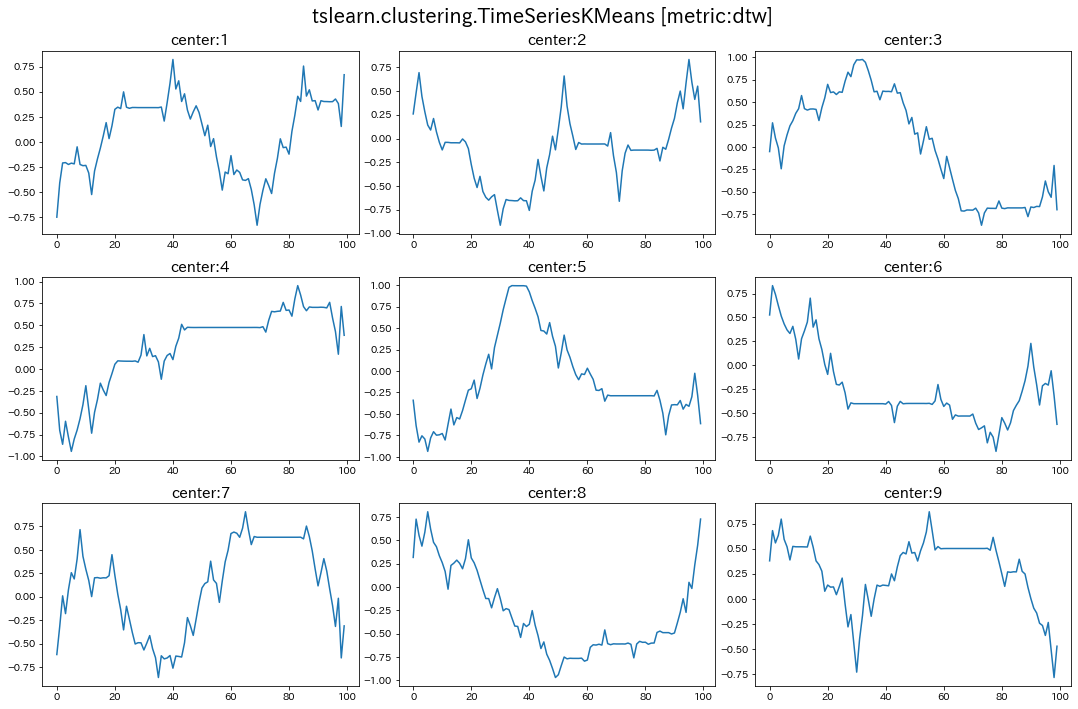

In [58]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km9.show_cluster(suptitle, 'center')

In [59]:
# クラスタ付近の小説を表示
km9.show_novels(df_merge, 5)

CLUSTER NUM:9
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 花火 (太宰 治,624)
https://www.aozora.gr.jp/cards/000035/card264.html
02: 聖女人像 (豊島 与志雄,516)
https://www.aozora.gr.jp/cards/000906/card42739.html
03: 三国志 [05 臣道の巻] (吉川 英治,5811)
https://www.aozora.gr.jp/cards/001562/card52413.html
04: 右門捕物帖 [24 のろいのわら人形] (佐々木 味津三,999)
https://www.aozora.gr.jp/cards/000111/card586.html
05: 右門捕物帖 [15 京人形大尽] (佐々木 味津三,565)
https://www.aozora.gr.jp/cards/000111/card576.html

Top Stories of center2:
01: 姥捨 (太宰 治,597)
https://www.aozora.gr.jp/cards/000035/card2256.html
02: いたずら小僧日記 (佐々木 邦,2711)
https://www.aozora.gr.jp/cards/001750/card55803.html
03: 春の盗賊 (太宰 治,925)
https://www.aozora.gr.jp/cards/000035/card266.html
04: うつり香 (近松 秋江,1297)
https://www.aozora.gr.jp/cards/000275/card1675.html
05: ドーヴィル物語 (岡本 かの子,675)
https://www.aozora.gr.jp/cards/000076/card46942.html

Top Stories of center3:
01: 野菊の墓 (伊藤 左千夫,978)
https://www.aozora.gr.jp/cards/000058/card647.html
02: 或る女 [2（後編）] (有島 武郎,5365)
https://www

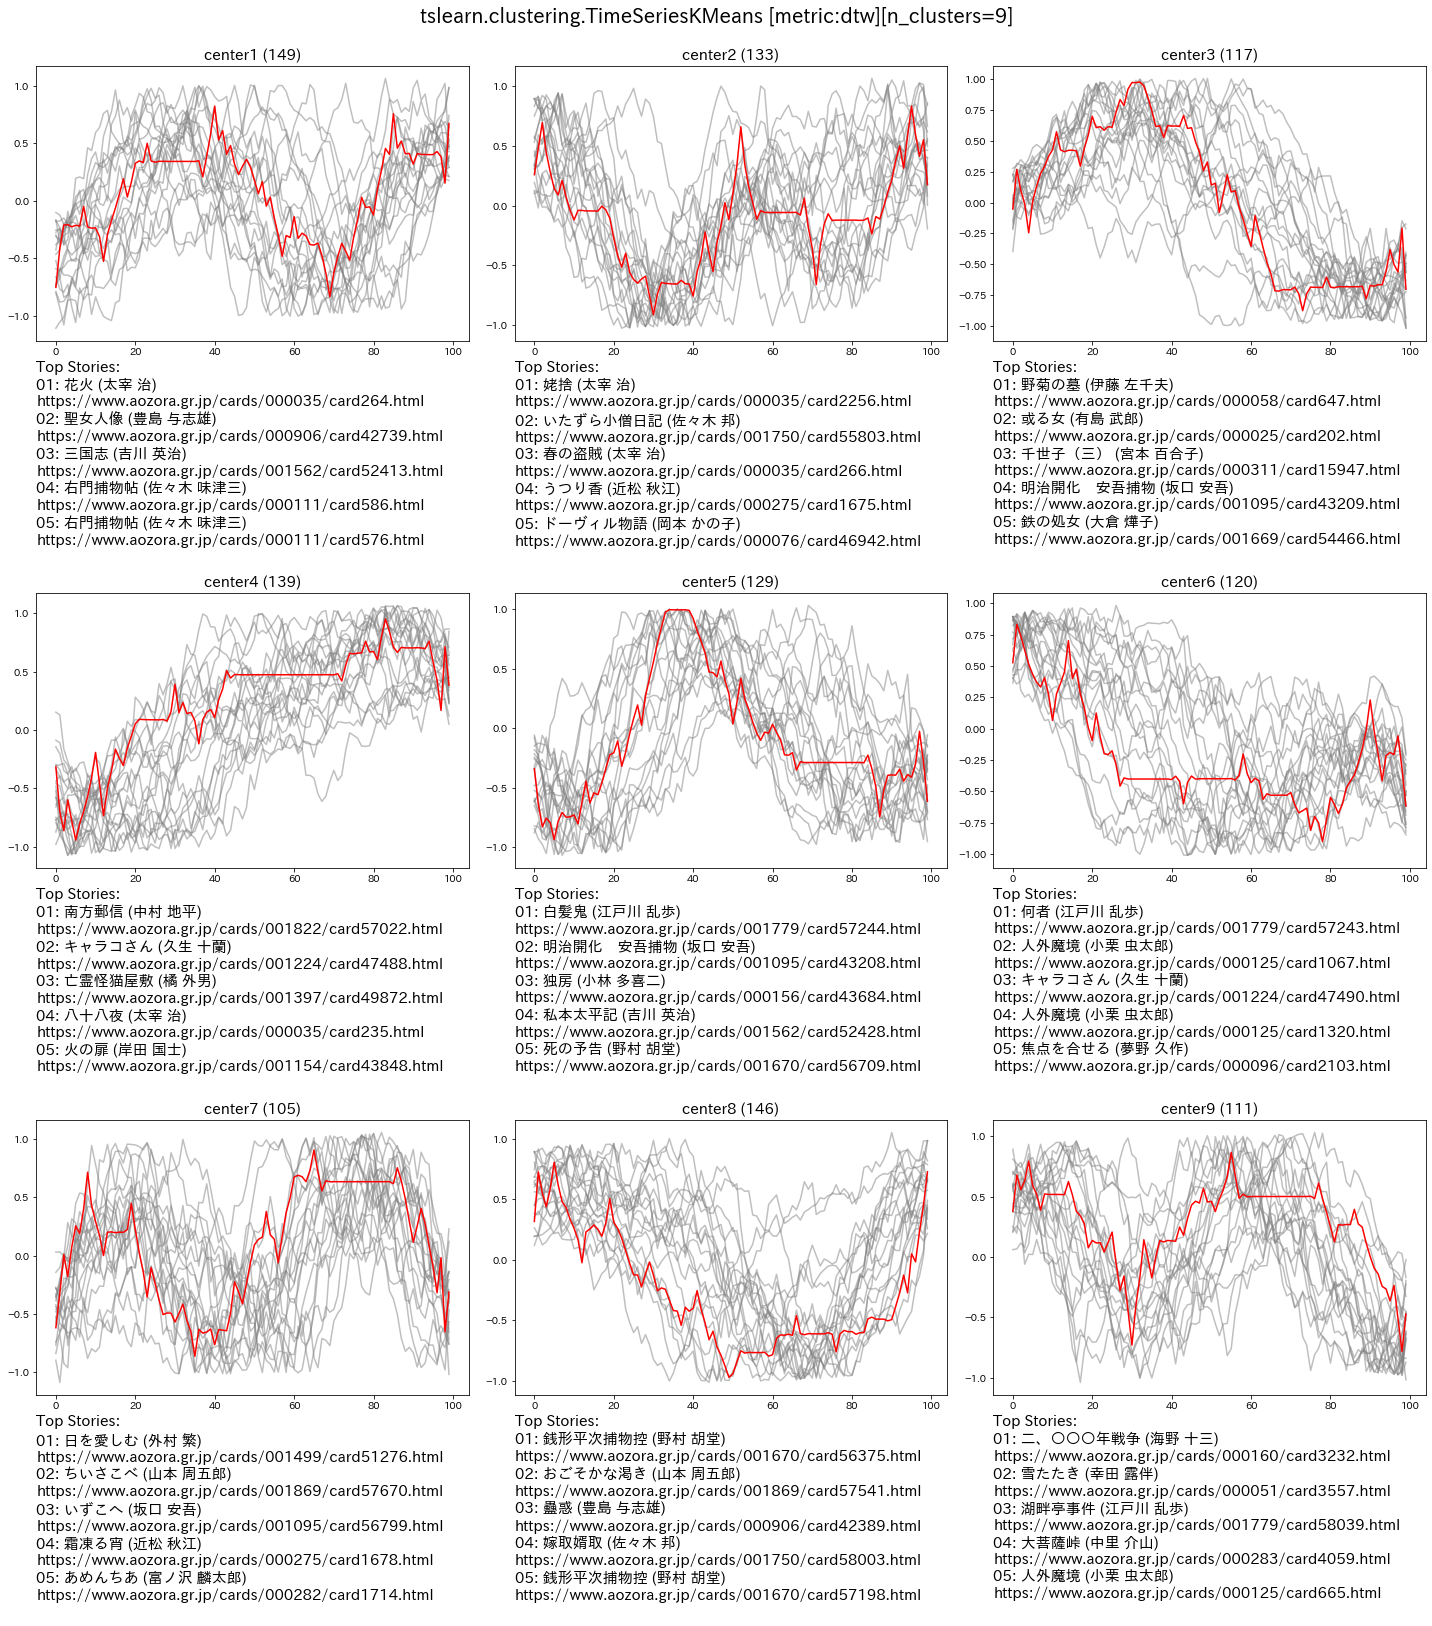

In [65]:
# クラスタとその付近の小説を視覚化
km9.show_cluster_sumples(df_merge, figsize=(20, 23), plot_cols=3)